# Описание проекта

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Нужно спрогнозировать сразу две величины:

* эффективность обогащения чернового концентрата *rougher.output.recovery;*
* эффективность обогащения финального концентрата *final.output.recovery.*

Итоговая метрика складывается из двух величин:

$$
Result = 0.25*sMAPE(roughter) + 0.75*sMAPE(final)
$$

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor

pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")

# 1. Подготовка данных

Для начала выгрузим все таблицы и посмотрим на сами данные.

In [2]:
train = pd.read_csv("/datasets/gold_recovery_train.csv")
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [3]:
test = pd.read_csv("/datasets/gold_recovery_test.csv")
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [4]:
full = pd.read_csv("/datasets/gold_recovery_full.csv")
full.info()
full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

## Эффективность обогащения

Для начала проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака *rougher.output.recovery*. Найдем MAE между нашими расчётами и значением признака.

$$
Recovery = {{C*(F-T)}\over{F*(C-T)}}
$$

In [5]:
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'rougher.output.tail_au'
R = 'rougher.output.recovery'

mae = 1/len(train)*np.sum(abs(train[R] - 100*(train[C] * (train[F] - train[T]))/(train[F] * (train[C] - train[T]))))
mae

9.235396156801791e-15

### Вывод

Значение MAE получилось очень маленькое, что говорит о правильности рассчета эффективности обогащения.


## Отличие выборок

Теперь проанализируем признаки, недоступные в тестовой выборке: что это за параметры и какому типу относятся.

In [6]:
print(train.shape[1]-test.shape[1])
train.info()
test.info()

34
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant          

В тестовой выборке на 34 параметра меньше. Там отсутствуют: 

* final.output(9 параметров)
* primary_cleaner.output(8 параметров)
* rougher.calculation(4 параметров)
* rougher.output(9 параметров)
* secondary_cleaner.output(4 параметров)

Т.е. отсутствуют все выходные параметры и параметры рассчета. Имеются только *input* и *state* параметры. 

Тестовая выборка содержит далеко не все поля. Это связано с тем, что большинство значений получают в процессе обработки руды. Следовательно, использовать эти значения в обучении модели нет смысла.


## Предобработка данных

Теперь проведем предобработку данных. Удалим записи с пропусками в целевом признаке, а затем заполним оставшиеся пропуски. Так как данные за соседнее время схожи, воспользуемся методом interpolate():

In [7]:
train = train.dropna(subset=['rougher.output.recovery','final.output.recovery']).reset_index(drop=True)
train = train.interpolate(method ='linear')
print("Количество пропусков:", train.isna().sum().sum())

Количество пропусков: 0


In [8]:
test = test.interpolate(method='linear')
print("Количество пропусков:", test.isna().sum().sum())

Количество пропусков: 0


In [9]:
full = full.dropna(subset=['rougher.output.recovery','final.output.recovery']).reset_index(drop=True)
full = full.interpolate(method ='linear')
print("Количество пропусков:", full.isna().sum().sum())

Количество пропусков: 0


Теперь все пропуски в данных заполнены и можно переходить к анализу.

# 2. Анализ данных

Проверим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Всего у нас 4 варианта состояния руды:

* Изначальное сырье
* После флотации
* После 1 этапа
* После 2 этапа

Построим график изменения средних для каждого металла на каждом этапе. Для этого сначала посчитаем сами средние:

In [10]:
means_au = full[['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']].mean()
means_ag = full[['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']].mean()
means_pb = full[['rougher.input.feed_pb','rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']].mean()
indexes = ['Сырье','После флотации','Первый этап очистки','Второй этап очистки']
means_au.index = indexes
means_ag.index = indexes
means_pb.index = indexes

Теперь выведем все на график:

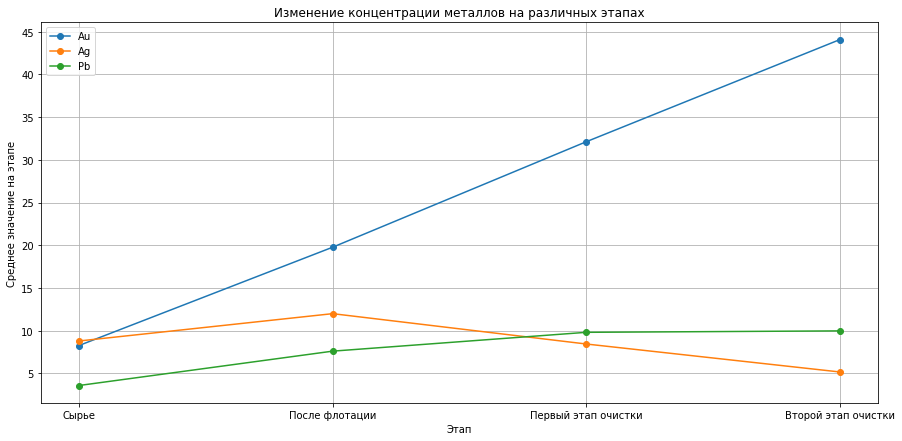

In [11]:
plt.figure(figsize=(15,7))
plt.title('Изменение концентрации металлов на различных этапах')
plt.xlabel('Этап')
plt.ylabel('Среднее значение на этапе')
plt.grid()
plt.plot(means_au, 'o-', label='Au')
plt.plot(means_ag, 'o-', label='Ag')
plt.plot(means_pb, 'o-', label='Pb')
plt.legend()
plt.show()

### Вывод 

Как видим, концентрация золота постоянно и линейно возрастает. Концентрация свинца тоже возрастает, но с намного меньшим коэффициентом. А вот концентрация серебра на этапе флотации возрастает, а на этапах очистки уменьшается.

Теперь построим гистограммы распределения для каждого металла на каждом этапе:

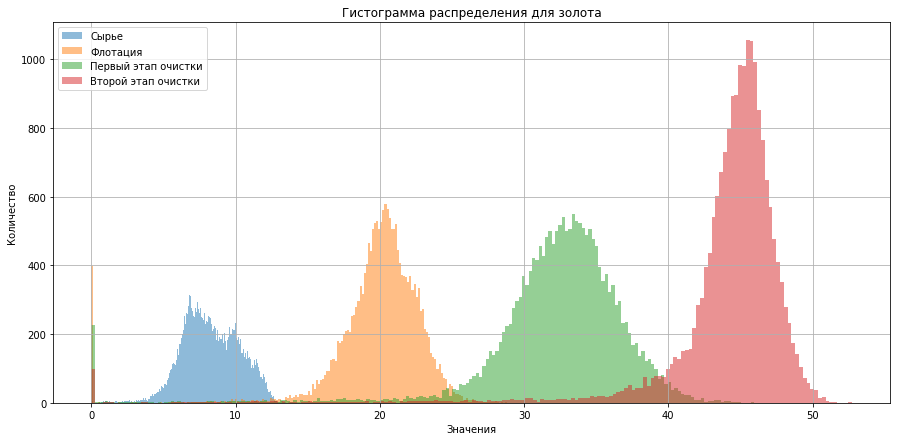

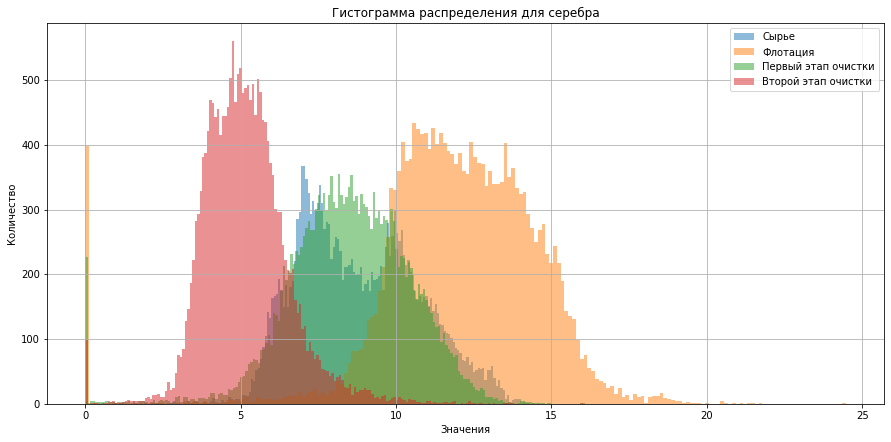

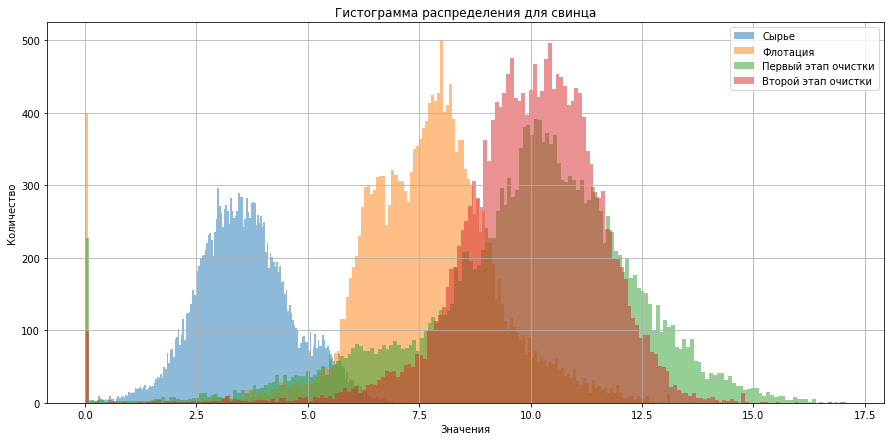

In [12]:
def draw_hist(before_flotation, after_flotation, after_1_wash, after_2_wash, title):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.xlabel('Значения')
    plt.ylabel('Количество')
    plt.grid()
    plt.hist(full[before_flotation], label='Сырье', bins=200, alpha=0.5)
    plt.hist(full[after_flotation], label='Флотация', bins=200, alpha=0.5)
    plt.hist(full[after_1_wash], label='Первый этап очистки', bins=200, alpha=0.5)
    plt.hist(full[after_2_wash], label='Второй этап очистки', bins=200, alpha=0.5)
    plt.legend()
    plt.show()
    
draw_hist('rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 'Гистограмма распределения для золота')
draw_hist('rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag', 'Гистограмма распределения для серебра')
draw_hist('rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb', 'Гистограмма распределения для свинца')

### Вывод

По гистограммам также видно, что наибольшие изменения в концентрации претерпевает золото. Но зато можно заметить, что сильно выделяются из распределения нулевые значения. Высока вероятность, что это выбросы.


## Сравним распределения

Теперь сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [13]:
print(train['rougher.input.feed_size'].describe())
test['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.097903
std         23.023690
min          9.659576
25%         48.950593
50%         55.269784
75%         65.982466
max        484.967466
Name: rougher.input.feed_size, dtype: float64


count    5856.000000
mean       55.886800
std        22.704970
min         0.046369
25%        43.865121
50%        49.964796
75%        61.615634
max       477.445473
Name: rougher.input.feed_size, dtype: float64

Численно данные кажутся похожими, давайте посмотрим на график распределения:

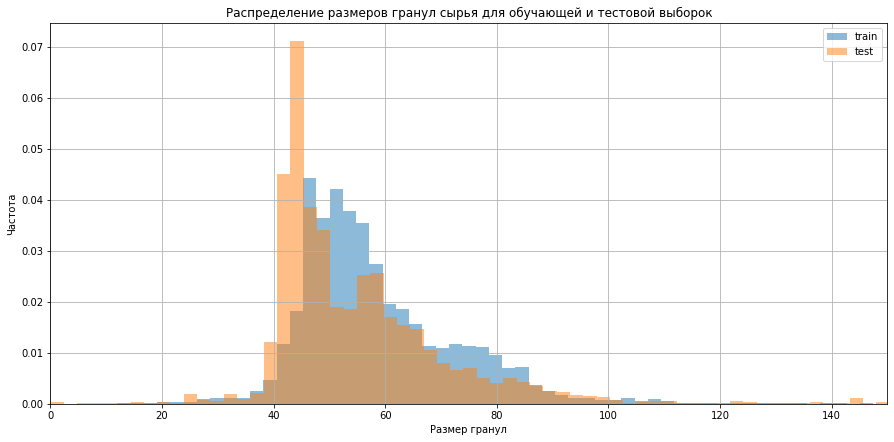

In [14]:
plt.figure(figsize=(15,7))
plt.title('Распределение размеров гранул сырья для обучающей и тестовой выборок')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.xlim(0,150)
plt.grid()
plt.hist(train['rougher.input.feed_size'], density=True, label='train', bins=200, alpha=0.5)
plt.hist(test['rougher.input.feed_size'], density=True, label='test', bins=200, alpha=0.5)
plt.legend()
plt.show()

### Вывод 

Смотря на график, я бы скорее предположил, что выборки имеют одинаковое распределение.

## Выбросы

Теперь исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [15]:
train['rougher_input_feed'] = train['rougher.input.feed_au'] + train['rougher.input.feed_ag'] + train['rougher.input.feed_pb']
train['rougher_output_concentrate'] = train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb']
train['final_output_concentrate'] = train['final.output.concentrate_au'] + train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] 
train[['rougher_input_feed','rougher_output_concentrate','final_output_concentrate']].describe()

,rougher_input_feed,rougher_output_concentrate,final_output_concentrate
count,14149.000000,14149.000000,14149.000000
mean,19.951755,38.880325,59.278554
std,4.430553,6.927062,5.707729
min,0.030000,0.000000,0.000000
25%,16.850944,37.925621,59.201505
50%,19.179708,39.860389,60.260341
75%,22.571605,41.796805,61.054829
max,32.840164,55.568687,64.968881


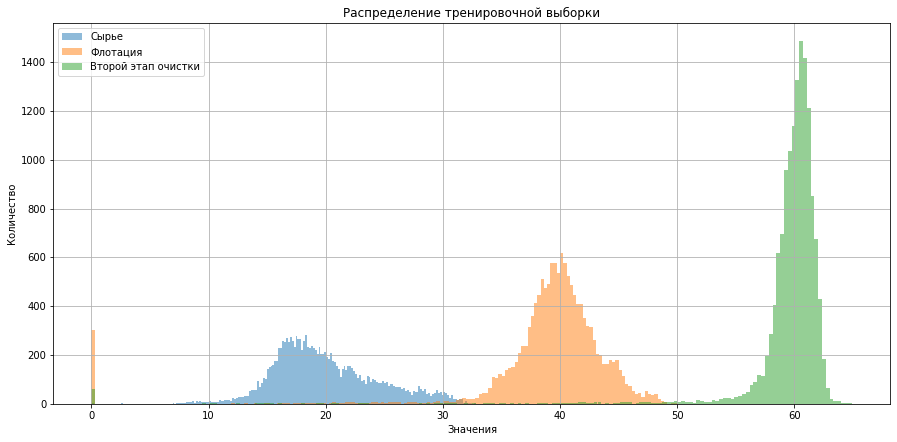

In [16]:
def draw_hist_2(data, title):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.xlabel('Значения')
    plt.ylabel('Количество')
    plt.grid()
    plt.hist(data['rougher_input_feed'], label='Сырье', bins=200, alpha=0.5)
    plt.hist(data['rougher_output_concentrate'], label='Флотация', bins=200, alpha=0.5)
    plt.hist(data['final_output_concentrate'], label='Второй этап очистки', bins=200, alpha=0.5)
    plt.legend()
    plt.show()
    
draw_hist_2(train,'Распределение тренировочной выборки')

В нуле отчетливо видны выбросы из общего распределения.

Теперь посмотрим на тестовую выборку. Для начала в датасете full рассчитаем недостающие нам суммы концентраций на этапах флотации и финальном. Затем подтянем их в тестовую выборку методом merge() с помощью поля 'date'. При этом сразу перенесем необходимые для дальнейшего обучения модели целевые признаки.

In [17]:
full['rougher_output_concentrate'] = full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb']
full['final_output_concentrate'] = full['final.output.concentrate_au'] + full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] 

test = test.merge(full[['date','rougher_output_concentrate','final_output_concentrate','rougher.output.recovery','final.output.recovery']], on='date', how='inner')

test['rougher_input_feed'] = test['rougher.input.feed_au'] + test['rougher.input.feed_ag'] + test['rougher.input.feed_pb']

test[['rougher_input_feed','rougher_output_concentrate','final_output_concentrate']].describe()

,rougher_input_feed,rougher_output_concentrate,final_output_concentrate
count,5290.000000,5290.000000,5290.000000
mean,22.504705,40.690860,59.077045
std,4.059340,6.509974,7.025685
min,1.410750,0.000000,0.000000
25%,19.817612,39.836990,59.521397
50%,22.982984,41.544465,60.444408
75%,25.114266,43.526204,61.198132
max,33.498784,50.105806,63.809530


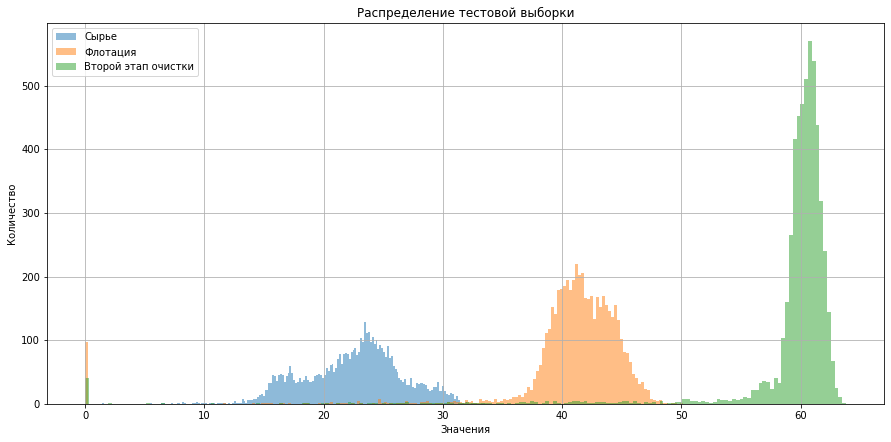

In [18]:
draw_hist_2(test, "Распределение тестовой выборки")

Как можно заметить, и в тренировочной и в тестовой выборке есть ситуации, когда суммарная концентрация всех веществ равна 0. Такие низкие значения являются аномальными. Их причиной может быть сбой в установке. 

Аномальные значения могут повлиять на результат обучения модели. Избавимся от них в обеих выборках.

In [19]:
errors_train = train.query("rougher_input_feed == 0 or rougher_output_concentrate == 0 or final_output_concentrate == 0")
print("Количество удаленных из тренировочной выборки строк:", errors_train.shape[0])
train = train.drop(errors_train.index).reset_index(drop=True)

Количество удаленных из тренировочной выборки строк: 354


In [20]:
errors_test = test.query("rougher_input_feed == 0 or rougher_output_concentrate == 0 or final_output_concentrate == 0")
print("Количество удаленных из тестовой выборки строк:", errors_test.shape[0])
test = test.drop(errors_test.index).reset_index(drop=True)

Количество удаленных из тестовой выборки строк: 136


Теперь заново построим графики распределения и убедимся что избавились от выбросов.

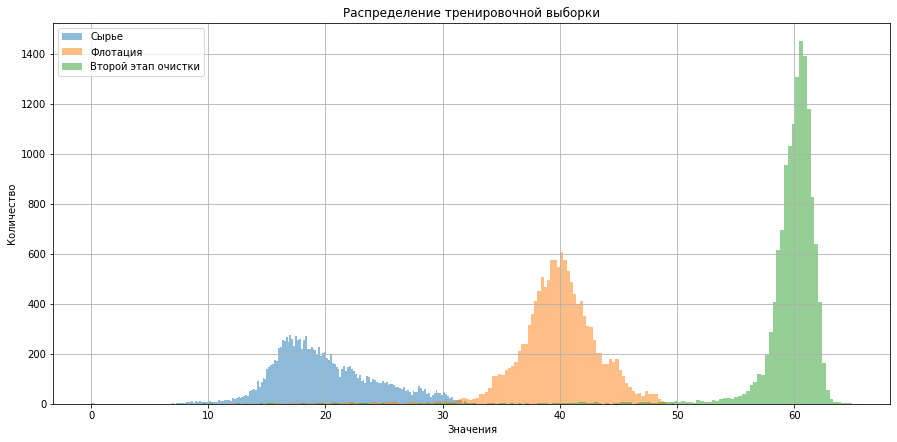

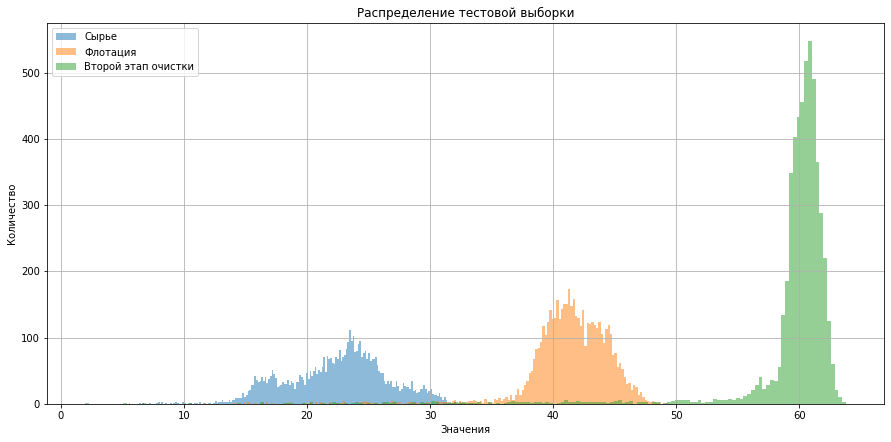

In [21]:
draw_hist_2(train,'Распределение тренировочной выборки')
draw_hist_2(test, "Распределение тестовой выборки")

Как видим, нам удалось избавиться от выбросов. Помимо этого, можно наблюдать, что тренировочная и тестовая выборки имеют похожие распределения, что должно хорошо сказаться на результате обучения модели.

Осталось удалить созданые нами столбцы:

In [22]:
train = train.drop(['rougher_input_feed','rougher_output_concentrate','final_output_concentrate'], axis=1)
test = test.drop(['rougher_input_feed','rougher_output_concentrate','final_output_concentrate'], axis=1)

### Вывод

Теперь данные не содержат аномальных нулей и можно перейти к процессу подбора и обучения модели.

# 3. Модель

Разобьем данные на факторные и результативные признаки. Сократим факторные признаки до тех, которые используются в тестовой выборке, и ещё удалим столбец date.

Нужно спрогнозировать сразу две величины:

* эффективность обогащения чернового концентрата *rougher.output.recovery;*
* эффективность обогащения финального концентрата *final.output.recovery.*

In [23]:
features = train[test.columns].drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
target = train[['rougher.output.recovery','final.output.recovery']]

Теперь для дальнейшей подготовки модели нам необходимо написать функцию, которая будет считать заданную нам метрику: sMAPE. При чем результирующая метрика должна рассчитываться по формуле 0.25 * sMAPE(roughter) + 0.75 * sMAPE(final). 

In [24]:
def smape(target, predictions):
    result = 100/len(target)*np.sum(abs(target-predictions)/((abs(target)+abs(predictions))/2))
    return result

def res_smape(target, predictions):
    rougher_score = smape(target['rougher.output.recovery'], predictions[:,0])
    final_score = smape(target['final.output.recovery'], predictions[:,1])
    return 0.25 * rougher_score + 0.75 * final_score

Теперь нужно заняться подбором подходящей модели. Рассмотрим 4 варианта:

* Дерево решений
* Случайный лес
* Линейная регрессия
* CatBoost

Превратим нашу функцию-метрику в scorer для того чтобы использовать её в кросс-валидации при подборе параметров.

In [25]:
scorer = make_scorer(res_smape, greater_is_better=False)

### Дерево решений

In [26]:
tree = DecisionTreeRegressor()
tree_params = {'max_depth': range(1,9)}
tree_clf = GridSearchCV(tree, tree_params, verbose=1, cv=4, scoring=scorer)
tree_clf.fit(features, target)
print("Параметры:", tree_clf.best_params_)
print("sMAPE:", tree_clf.best_score_*-1)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    9.6s finished


Параметры: {'max_depth': 4}
sMAPE: 9.567603265380841


### Случайный лес

In [27]:
forest = RandomForestRegressor()
forest_params = {'max_depth':[3,4,5,6,7], 'n_estimators':[120,125,130]}
forest_clf = GridSearchCV(forest, forest_params, verbose=1, cv=4, scoring=scorer)
forest_clf.fit(features, target)
print("Параметры:", forest_clf.best_params_)
print("sMAPE:", forest_clf.best_score_*-1)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 25.9min finished


Параметры: {'max_depth': 3, 'n_estimators': 125}
sMAPE: 9.37423539534243


### Линейная регрессия

In [28]:
regr = LinearRegression()
regr_clf = GridSearchCV(regr, {}, verbose=1, cv=4, scoring=scorer)
regr_clf.fit(features, target)
print("sMAPE:", regr_clf.best_score_*-1)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   23.8s finished


sMAPE: 10.603046753873615


### CatBoost

In [29]:
cat = CatBoostRegressor(loss_function='MultiRMSE', 
          eval_metric='MultiRMSE',verbose=0)
cat_params = {'learning_rate':[0.01,0.05], 'iterations':[500,1000]}
cat_clf = GridSearchCV(cat, cat_params, verbose=1, cv=4, scoring=scorer)
cat_clf.fit(features, target)
print("Параметры:", cat_clf.best_params_)
print("sMAPE:", cat_clf.best_score_*-1)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 20.6min finished


Параметры: {'iterations': 1000, 'learning_rate': 0.01}
sMAPE: 9.197033043609803


Лучший результат показывает модель градиентного бустинга со скоростью обучения 0.01 и количеством итераций 1000. Теперь обучим модель с заданными параметрами и проверим ее качество на тестовой выборке. 

### Проверка на тестовой выборке


Для начала удалим столбец date и разделим признаки на факторные и результативные:

In [30]:
features_test = test.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
target_test = test[['rougher.output.recovery','final.output.recovery']]

Наконец проверим модель на тестовой выборке:

In [31]:
model = CatBoostRegressor(loss_function='MultiRMSE', eval_metric='MultiRMSE', 
                          verbose=0, learning_rate=0.01, iterations=1000)
model.fit(features, target)
predictions = model.predict(features_test)
score = res_smape(target_test, predictions)
print("Значение sMAPE на тестовой выборке:", score)

Значение sMAPE на тестовой выборке: 6.772074491302222


## Вывод

Необходимо было подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна была предсказать **коэффициент восстановления золота из золотосодержащей руды**. В нашем распоряжении были данные с параметрами добычи и очистки. 

Нужно было спрогнозировать сразу **две величины**:

* эффективность обогащения чернового концентрата *rougher.output.recovery;*
* эффективность обогащения финального концентрата *final.output.recovery.*

Сначала была проверена правильность расчета эффективности обогащения. Затем были сравнены признаки в тренировочной и тестовой выборке, и были определены необходимые для обучения факторные переменные.

Затем данные были **проанализированы** и **предподготовлены**:

* Пропуски заполнены методом интерполяции
* Удалены аномальные нули в данных о концентрации веществ

Затем были перебраны различные варианты моделей *(решающее дерево, случаный лес, линейная регрессия, градиентный бустинг)* с помощью кросс-валидации, и была выбрана модель с наилучшими результатами необходимой нам метрики.

Наилучшая модель - это **градиентный бустинг** с параметрами:

* скорость обучения 0.01
* количество итераций 1000

Он дает нам результат метрики равный 6.77 на тестовой выборке, что даже лучше, чем результат при кросс-валидации.